In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import sys
from SPARQLWrapper import SPARQLWrapper, JSON
import ast
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing

import datetime as dt

(!pip install -U scikit-learn)

# **STEP 0: Data opening and preprocessing**

The data in the CMU Movie Summary Corpus contains a collection of 42,306 movie plot summaries and metadata at both the movie level (including box office revenues, genre and date of release) and character level (including gender and estimated age):

**Data:**
1. `plot_summaries.txt.gz` [29 M]: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.
2. `corenlp_plot_summaries.tar.gz` [628 M, separate download]: to downlaod if considered useful... The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

**Metadata:**
1. `movie.metadata.tsv.gz` [3.4 M]: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie name
- Movie release date
- Movie box office revenue
- Movie runtime
- Movie languages (Freebase ID:name tuples)
- Movie countries (Freebase ID:name tuples)
- Movie genres (Freebase ID:name tuples)
2. `character.metadata.tsv.gz` [14 M]: Metadata for 450,669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:
- Wikipedia movie ID
- Freebase movie ID
- Movie release date
- Character name
- Actor date of birth
- Actor gender
- Actor height (in meters)
- Actor ethnicity (Freebase ID)
- Actor name
- Actor age at movie release
- Freebase character/actor map ID
- Freebase character ID
- Freebase actor ID

**Test data**:
1. `tvtropes.clusters.txt`: 72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.
2. `name.clusters.txt`: 970 unique character names used in at least two different movies, along with 2,666 instances of those types. The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.

### Data loading and pre-processing

In [2]:
data_folder = './MovieSummaries/'
characters = pd.read_csv(data_folder + 'character.metadata.tsv', sep='\t', header=None)
movies = pd.read_csv(data_folder + 'movie.metadata.tsv', sep='\t', header=None)
plot_summaries = pd.read_csv(data_folder + 'plot_summaries.txt', sep='\t', header=None)
character_types = pd.read_csv(data_folder + 'tvtropes.clusters.txt', sep='\t', header=None)
name_clusters = pd.read_csv(data_folder + 'name.clusters.txt', sep='\t', header=None)

In [3]:
characters.columns =['Wikipedia_movie_ID', 
                     'Freebase_movie_ID', 
                     'Movie_release_date', 
                     'Character_name', 
                     'Actor_birth', 
                     'Actor_Gender', 
                     'Actor Height', 
                     'Actor_Ethnicity', 
                     'Actor_Name', 
                     'Age_at_movie_release', 
                     'Freebase_character_actor_map_ID', 
                     'Freebase_character_ID', 
                     'Freebase_actor_ID']

movies.columns =['Wikipedia_movie_ID', 
                 'Freebase_movie_ID', 
                 'Name',
                 'Release_date', 
                 'Box_office_revenue', 
                 'Runtime',
                 'Languages', 
                 'Countries', 
                 'Genres']

plot_summaries.columns =['Wikipedia_movie_ID', 'Summary']
character_types.columns =['Type', 'Info']
name_clusters.columns =['Character_name', 'Freebase_character_actor_map_ID']

clean date:

In [4]:
movies.Release_date.iloc[62836] =  pd.to_datetime('2010-12-02') 
movies['Release_date'] = pd.to_datetime(movies['Release_date'])

C:\Users\Nate\AppData\Local\Temp\ipykernel_2084\2605603465.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies.Release_date.iloc[62836] =  pd.to_datetime('2010-12-02')


let get the information about the ethnicity via wikimedia


In [5]:
ethnicity_id = list(characters['Actor_Ethnicity'].value_counts().index)
for e in ethnicity_id : print('"'+e+'"',end=' ')

"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m

In [6]:
#pip install sparqlwrapper
#https://rdflib.github.io/sparqlwrapper/

endpoint_url = "https://query.wikidata.org/sparql"

query1 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/044038p" "/m/075_n6" "/m/0bbz66j" "/m/02rbdlq" "/m/0bkbz" "/m/01336l" "/m/04dbw3" "/m/0fqz6" "/m/06j2v" "/m/046cwm" "/m/0g6ff" "/m/0432mrk" "/m/0gkxl2" "/m/02p1pl6" "/m/03w9bjf" "/m/04tvpv" "/m/027n1m6" "/m/09743" "/m/0bhsnb" "/m/013b6_" "/m/048sp5" "/m/0h2138" "/m/02y_9mh" "/m/02jvpv" "/m/0dbxy" "/m/02vsw1" "/m/08cjt2" "/m/013s3n" "/m/09zyn5" "/m/0cm7w1" "/m/04q7gbh" "/m/0fj1k9" "/m/0fqp6zk" "/m/04f581" "/m/012c1l" "/m/071x0k" "/m/0ffjqy" "/m/0ffkb4" "/m/0g5y6" "/m/0bzkm2" "/m/0dllcfn" "/m/04y8_bm" "/m/03gskx0" "/m/0268d21" "/m/019lrz" "/m/02p4q5p" "/m/04czx7" "/m/02p656s" "/m/0ffhz3" "/m/04jq32s" "/m/04mmhj" "/m/0dj8k3" "/m/059_w" "/m/01kg2v" "/m/0222hg" "/m/0f0gt_" "/m/01j2qv" "/m/0ffjvd" "/m/032j30" "/m/033njm" "/m/0bs7l_v" "/m/0g48m4" "/m/022fdt" "/m/052r3t" "/m/0bfjm7" "/m/01xttr" "/m/04ydrsn" "/m/03295l" "/m/06lshc" "/m/03cbkrf" "/m/0283js_" "/m/09cqth" "/m/04nrnz" "/m/05748" "/m/025_0f0" "/m/01trsl" "/m/09vmyh" "/m/05sf2x" "/m/09gk_6h" "/m/078vc" "/m/01p7s6" "/m/017sq0" "/m/018s6c" "/m/04y29" "/m/067lts" "/m/05g0f1" "/m/0761bp" "/m/09gp4" "/m/02qv_h_" "/m/0640_7q" "/m/0912ll" "/m/013b7g" "/m/067lrj" "/m/0b79c7" "/m/09lz9zx" "/m/01swvz" "/m/01nbcy" "/m/0b0gzf" "/m/071drf" "/m/027vy0s" "/m/0150zs" "/m/0278pqj" "/m/0747611" "/m/0c2hxm" "/m/0462jl6" "/m/074w_m" "/m/04ggbzy" "/m/0hbz9xw" "/m/0152s7" "/m/0fng3k" "/m/0j4w_" "/m/0b98sy" "/m/08v2k7" "/m/0j6x8" "/m/0d9q7j" "/m/016f5d" "/m/0ffj5g" "/m/0338zd" "/m/04_tz7" "/m/027lf0d" "/m/0ch3pqf" "/m/06fczy" "/m/01mw1s" "/m/04608z" "/m/04_hr_" "/m/026cybk" "/m/01hwt" "/m/08gzsf" "/m/05vhv7" "/m/04_bc8" "/m/06rd7" "/m/0318mh" "/m/02wcbj_" "/m/0520604" "/m/07j80c" "/m/078ds" "/m/0fk1z" "/m/0dv5vw" "/m/04znbg" "/m/01sq7s" "/m/0gf5k1" "/m/03pqwy" "/m/031_sd" "/m/012f86" "/m/092h2qt" "/m/033qxt" "/m/03vghh" "/m/0bjbszh" "/m/07hyjp" "/m/03yk6g" "/m/0h1nk0k" "/m/04zjjt" "/m/02czfr" "/m/05qb937" "/m/047l_90" "/m/0bnzjx" "/m/02q206y" "/m/0665pp" "/m/07gzw5" "/m/062_25" "/m/0hj35" "/m/0bh91q8" "/m/01g0y_" "/m/07lv5x" "/m/0g4pffv" "/m/0828vj" "/m/07d_p8" "/m/04lhn7b" "/m/0fq6zlv" "/m/0268pvf" "/m/0466nw8" "/m/04pnf" "/m/02p_gby" "/m/06k6sl" "/m/0738n4" "/m/0266mf0" "/m/0cx3p" "/m/04kbvpz" "/m/07s9g04" "/m/04l_pt" "/m/026c9dq" "/m/01ylpf" "/m/0g5k7qv" "/m/01tyl3" "/m/0b__fv3" "/m/02vkd28" "/m/013s41" "/m/047948f" "/m/067lwk" "/m/03d19xz" "/m/02gx2x" "/m/021pd" "/m/013s2p" "/m/09fqz7" "/m/0ffhvl" "/m/075dhf0" "/m/02dd5z" "/m/03wbmrc" "/m/0br_8h" "/m/097nms" "/m/02cm28" "/m/0h6mqq9" "/m/09tqq8q" "/m/0301y_" "/m/0d8qh0" "/m/03h1dq9" "/m/03fk0c" "/m/026kx7g" "/m/04k02l" "/m/051wcch" "/m/026zlyd" "/m/01n94b" "/m/04dzwby" "/m/0btrm4" "/m/03ndvw" "/m/0fxmtg" "/m/04sfz4s" "/m/03cnzsg" "/m/03r_k" "/m/03f3sf" "/m/04lfc70" "/m/02vkw95" "/m/09y7x4" "/m/0fk3s" "/m/0h8mzsl" "/m/02p444n" "/m/03kbr" "/m/0bns36b" "/m/0bbcnlt" "/m/046j25" "/m/0dq1q" "/m/02rdfpy" "/m/05c60ml" "/m/0470lk" "/m/02p7gyv" "/m/0c29q8" "/m/03ck8x1" "/m/042199j" "/m/0bms44" "/m/01nft3" "/m/01d7kx" "/m/01c034" "/m/05cc9h" "/m/03cl2pz" "/m/03x_lpj" "/m/02rp50t" "/m/03m3p6w" "/m/02r_qms" "/m/086wp0" "/m/065z7w_" "/m/01f9bg" "/m/03sx6v" "/m/034s7b" "/m/0987ctr" "/m/03gy1h2" "/m/0c_lbq" "/m/03ftx7" "/m/067lv3" "/m/0g44f5" "/m/03d26m9" "/m/0165md" "/m/0dqrh8" "/m/0cc5y74" "/m/0289z8v" "/m/01267" "/m/0fpjs3j" "/m/03cdk7b" "/m/0bfrrj" "/m/04wy6k" "/m/03zcwh" "/m/0dc58y8" "/m/0g5rkt4" "/m/0647lm" "/m/04fh1b" "/m/047bp1r" "/m/09cd0m" "/m/03fvrb" "/m/025x6k1" "/m/02rm7_9" "/m/01l0ty" "/m/07s49c2" "/m/03ty8_" "/m/02m0kh" "/m/05ms3p0" "/m/0gtwjz6" "/m/0ftlzz" "/m/02pzb09" "/m/05sycg" "/m/051x6yk" "/m/01vsch" "/m/04csgrq" "/m/064b9n" "/m/09chmw" "/m/095mw2" "/m/09snp5" "/m/025tvhm" "/m/0c41n" "/m/01_5cg" "/m/025xss1" "/m/0404kdr" "/m/0ftwg" "/m/0790v" "/m/02r3wfk" "/m/03h11s3" "/m/01vr3v" "/m/0c3wsgg" "/m/06y24j" "/m/0ckk60" "/m/03lnnd" "/m/04hlx1" "/m/062zk4r" "/m/097r55" "/m/0b8yvr" "/m/0br_9j" "/m/0xff" "/m/01crfj" "/m/05mtdy" "/m/065577s" "/m/0fp4n" "/m/0301xt" "/m/01kb9y" "/m/0268xtg" "/m/05y2yj" "/m/0ffk5n" "/m/02vys3l" "/m/01h4n" "/m/0bvnws" "/m/06dy2k" "/m/08yg47" "/m/08c25t" "/m/0bvjpj" "/m/03x1x" "/m/0dn1_0" "/m/02qv716" "/m/02r11hz" "/m/06bkf" "/m/035b50" "/m/0166vx" "/m/01g3rx" "/m/06w4lv" "/m/04wysy" "/m/064pj" "/m/013z8m" "/m/04118b" "/m/064rb5l" "/m/01ywdy" "/m/01flqq" "/m/0960kn" "/m/0180zw" "/m/0463n9y" "/m/0d32d1" "/m/07n8wy" "/m/03q819" "/m/06vb7b" "/m/02pj9yr" "/m/03hf_6z" "/m/01km_m" "/m/062szv5" "/m/07g8yp" "/m/0fk55" "/m/04lgl9t" "/m/0444sm4" "/m/03m9my8" "/m/03cjjy0" "/m/03cmqbt" "/m/0b3zsn" "/m/03b_13l" "/m/0152wh" "/m/05ysft4" "/m/05sng" "/m/059v8" "/m/09c8kp" "/m/04jtjvt" "/m/04c28" "/m/03sk2" "/m/05ztd1" "/m/0dm3xpw" "/m/03hjx6f" "/m/026d074" "/m/03nvq" "/m/03nz70" "/m/029q52" "/m/02wz7j" "/m/04kdwcx" "/m/02ry8mk" "/m/07wsyr" "/m/09r2kh" "/m/04_8lfc" "/m/033qt1" "/m/012fh" "/m/08j1fb" "/m/027936c" "/m/0dtkkb" "/m/05bzpzx" "/m/04lhnps" "/m/0fp54b" "/m/01hm_" "/m/0288fw3" "/m/0ft9bs" "/m/01gr8h" "/m/09g34_" "/m/0d8qls" "/m/08xbxs" "/m/032m0b" "/m/04hqxn" "/m/068y7m" "/m/044bp_" "/m/039z49" "/m/047q05d" "/m/0c50f" "/m/01srl7" "/m/0fpxlz9" "/m/0bdynxs" "/m/01gby2" "/m/043_z22" "/m/03x_fq7" "/m/01hphz" "/m/033fjj" "/m/013y54"}.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

query2 = """PREFIX wdt: <http://www.wikidata.org/prop/direct/>
SELECT DISTINCT ?id ?itemLabel WHERE {
  VALUES ?id {"/m/0dryh9k" "/m/0x67" "/m/041rx" "/m/02w7gg" "/m/033tf_" "/m/0xnvg" "/m/02ctzb" "/m/07hwkr" "/m/07bch9" "/m/044038p" "/m/03bkbh" "/m/0d7wh" "/m/03ts0c" "/m/0222qb" "/m/01rv7x" "/m/02sch9" "/m/04mvp8" "/m/03lmx1" "/m/065b6q" "/m/01qhm_" "/m/06mvq" "/m/048z7l" "/m/0bpjh3" "/m/0cqgdq" "/m/0g8_vp" "/m/09vc4s" "/m/013xrm" "/m/019kn7" "/m/06gbnc" "/m/07mqps" "/m/01g7zj" "/m/01xhh5" "/m/03bx0k4" "/m/0g96wd" "/m/02g7sp" "/m/09m6hr" "/m/063k3h" "/m/0g0x7_" "/m/03ttfc" "/m/023mqw" "/m/0d2by" "/m/09kr66" "/m/042gtr" "/m/025rpb0" "/m/08hpk0" "/m/038723" "/m/0583cz" "/m/022dp5" "/m/0cmdl5l" "/m/03vv99" "/m/029f2r" "/m/09k5jvk" "/m/0cnvdq1" "/m/06v41q" "/m/04gfy7" "/m/0bymc" "/m/0cn68" "/m/09v5bdn" "/m/05l3g_" "/m/0268_k" "/m/0dqqwy" }.
   ?item wdt:P646 ?id.
    
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

#we separated the analysis to respect the maximal size of the function's capacity
results1 = get_results(endpoint_url, query1)
results2 = get_results(endpoint_url, query2)

In [7]:
for result in results1["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)

for result in results2["results"]["bindings"]:
    characters['Actor_Ethnicity'].replace(result['id']['value'],result['itemLabel']['value'],inplace=True)
characters.head(3)

,Wikipedia_movie_ID,Freebase_movie_ID,Movie_release_date,Character_name,Actor_birth,Actor_Gender,Actor Height,Actor_Ethnicity,Actor_Name,Age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,African Americans,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


Let's clean the `movies` dataframe to remove the language, country and genre indices in front of each value using the regex `re` library. We can also create lists of genres for each movie instead of a long string in the `Genres` column. This pre-processing is done below.

In [8]:
movies[['Genres']] = movies[['Genres']].applymap(ast.literal_eval)

def replace_dicts(arg):
    return list(arg.values())

movies[['Genres']] = movies[['Genres']].applymap(replace_dicts)

In [9]:
movies['Languages'] = movies['Languages'].apply(lambda x: re.findall('": "(.*)"', x)).str[0]
movies['Countries'] = movies['Countries'].apply(lambda x: re.findall('": "(.*)"', x)).str[0]

In the `character_types` dataframe above, the `Info` column contains long strings that give information about the character that the character type describes, the movie in which the character is found, the Freebase character/actor map ID and the actor that embodies the character. All of this information can be separated into four disctint columns: character, movie, ID and actor columns, using the `json` library as below. 

In [10]:
character_types[['char', 'movie', 'Freebase_character_actor_map_ID', 'actor']] = character_types['Info'].apply(lambda x: json.loads(x)).apply(pd.Series)
character_types.drop('Info', axis=1, inplace=True)


### first Vizualisation

In [11]:
print(f'Movies dataframe has {len(movies)} rows')
print(f'Characters dataframe has {len(characters)} rows')
print(f'Plot_summaries dataframe has {len(plot_summaries)} rows')
print(f'Character_types dataframe has {len(character_types)} rows')
print(f'Name_clusters dataframe has {len(name_clusters)} rows')

Movies dataframe has 81741 rows
Characters dataframe has 450669 rows
Plot_summaries dataframe has 42303 rows
Character_types dataframe has 501 rows
Name_clusters dataframe has 2666 rows


Therefore, each of our da

In [12]:
movies_datetime=movies.dropna()
movies_datetime = movies_datetime.groupby((pd.to_datetime(movies_datetime['Release_date']).dt.to_period('Y'))).apply(lambda x: pd.Series({
    'mean_runtime': x['Runtime'].mean(),
    'mean_box_office_revenue': x['Box_office_revenue'].mean(),
    'num_movies': len(x),
}))

In [13]:
movies_datetime.head()

,mean_runtime,mean_box_office_revenue,num_movies
Release_date,,,
1914,74.0,2.447000e+05,1.0
1915,190.0,5.000000e+07,1.0
1920,147.0,4.500000e+06,1.0
1921,102.0,2.633333e+06,3.0
1923,84.5,3.834395e+06,2.0


<AxesSubplot: >

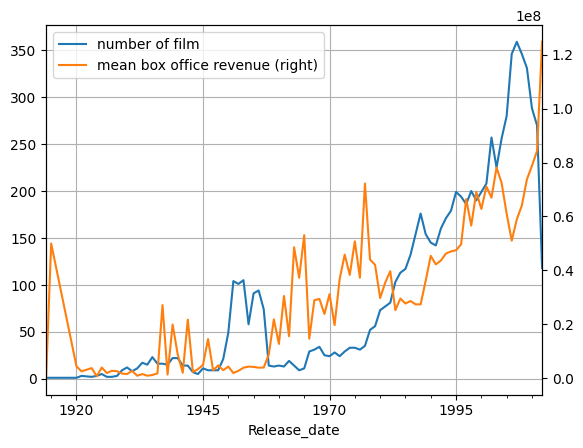

In [14]:
movies_datetime.num_movies.plot(grid=True, label="number of film", legend=True)
movies_datetime.mean_box_office_revenue.plot(secondary_y=True, label="mean box office revenue", legend=True)

In [15]:
print(f'Movie year of release span from {movies_datetime.index.min()} to {movies_datetime.index.max()}.')
print('Our dataset have', (movies_datetime.num_movies==0).sum(), ' year(s) where no films where released.')

Movie year of release span from 1914 to 2012.
Our dataset have 0  year(s) where no films where released.


Since there is not any year without a movie release, any distribution of a movie characteristic will be continuous over time and will thus be possible to analyze. Moreover, we can think to have some correlation between the number of movies and the box office revenue. However, with this first plot, we cannot conclude something.

<AxesSubplot: >

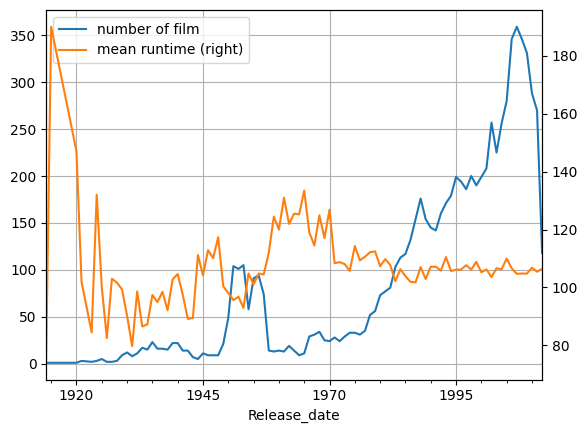

In [16]:
movies_datetime.num_movies.plot(grid=True, label="number of film", legend=True)
movies_datetime.mean_runtime.plot(secondary_y=True, label="mean runtime", legend=True)

In [17]:
np.mean(movies_datetime.mean_runtime)

107.08092609768111

Here, we can see that the runtime fluctuated during the first 50th years but then the runtime is around 100min with less fluctuation with time. However this a good example of the attention we will have to pay to the 'weights' through the years. Indeed during first 50th years there are a lot of fluctuations of the mean runtime but the fact that these years contains only a few movies make it difficult to estimate a global tendency. Maybe these years should be grouped. In comparison, the fluctuation is less important during the last 50 years but the samples size by year are larger, thus it follows by law of large numbers that the means will be closer to the expected value (the reasoning is valable if we assume that the expected mean runtime is the same for each year).

*A voir si c'est utile d'ajouter les plots directement au movie dataset...*

### Some data combination

In [18]:
movies_plot = movies.merge(plot_summaries, on="Wikipedia_movie_ID")


In [19]:
merge_characters_type = pd.merge(characters, character_types, on='Freebase_character_actor_map_ID', suffixes=('', '_y'))


In [20]:
merge_characters_type.drop(['char','actor'],axis=1, inplace=True)


In [21]:
merge_characters_type = pd.merge(merge_characters_type, movies[['Wikipedia_movie_ID', 'Languages', 'Countries', 'Genres', 'Box_office_revenue', 'Runtime']], on='Wikipedia_movie_ID', suffixes=('', '_y'))


# **STEP 1: dictionnary definitions**

Trick: could add spaces in front of words that are ambiguous. Example below with SS: a lot of words contain the sequence ss, but space+ss is rare. We could even consider space+ss++space, but this would exclude some occurances due to punctuation.

### Worl War 1

In [22]:
WW1 =  ['WW1', 'World War 1', '1914', '1918', 'Allies', 'armistice', 'Central Powers', 'conscription', 'front line', 'Joffre', 'Kaiser', 'Marne',
        'mustard gas', 'no man’s land', 'Pétain', 'u boats', 'Somme', 'Tommy', 'Treaty of Versailles', 'trench', 'Verdun', 'Western front', 
        'zeppelin', 'artillery', 'doughboy', 'duckboards', 'dreadnought', 'mobilize', 'Prussia', 'Schlieffen plan', 'Tsar', 'Archduke Ferdinand',
        'Red Baron', 'big four', 'Christmas truce', 'Wilson', 'Lusitania', 'Battalion', 'triple entente', 'Great War', 'flamethrower', 'mills bomb',
        'storm troop', 'ace', 'recco', 'tailspin', 'boche', 'wipers', 'kiwi', 'Sammy', 'Aussie', 'cootie', 'Flanders', 'mud', 'war effort', 
        'League of Nations']
WW1 = [x.lower() for x in WW1]

### World War 2

In [23]:
WW2 =  ['Allies','Auschwitz','Bombardment', 'battleship', 'Bailey bridge', 'Blitzkrieg','Churchill','D-Day',' ss'
        'Dunkirk', 'Doolittle', 'de Gaulle','English Channel', 'Eisenhower','Enigma','flying tigers', 'free french',
        'nazi','helmet','Hiroshima','Invasion','Luftwaffe','Manhattan Project', 'Midway','Pearl harbor','Normandy', 'Nagasaki',
        'Panzer','Roosevelt', 'Rangers','Resistance','Truman', 'Stalin', 'tank','Victory', 'V-1 rocket','doodlebugs',
        'World War II','ww2','Hitler','air raid','shelter','siren','Battle of Britain','evacuee','evacuation','gas mask',
        'spitfire', '1939', '1945']
WW2 = [x.lower() for x in WW2]

### Space race

In [24]:
Space = ['aeronautics','Alan Shepard','Apollo','Cape Canaveral','capitalism','Cold War','Communism','Gemini','heat shields', 
         'Houston','John Glenn','Laika','launch','Lunar Module','Mercury','Michael Collins','Mission Control','NASA','neil Armstrong',
         'orbit','planet','rocket','satellite','Scott Carpenter','Sergei Korolev','solar system','space','space exploration','Space Race',
         'Sputnik','superpowers','test pilot',' USA',' URSS','Yuri Gagarin']
Space = [x.lower() for x in Space]

### Metric

If we do number of words, it could depend too much on the length of the plot summary or the length and quality of the dictionnary. Thus, a min-max scaling or standardization could be usefull afterward in the feature space. 

## ?on pourrait définir un % du numbre de mot?

# **STEP 2: Apply dictionnaries to plot summaries to create new features**

lower case every plot summary:

In [25]:
summaries = movies_plot.Summary.apply(lambda h: h.lower())

Count the number of times word from a given dictionnary occurs in a plot summary. This function creates a new column in the movies_plot DF.

In [26]:
def count_dict(name,dictionnary):
    movies_plot[name] = summaries.apply(lambda summary: np.sum([summary.count(word) for word in dictionnary]))
                                          

In [27]:
count_dict('WW1',WW1)
count_dict('WW2',WW2)
count_dict('SpaceRace',Space)

In [28]:
len(movies_plot[movies_plot.WW2 > 10])

62

In [29]:
movies_plot.head()

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,WW1,WW2,SpaceRace
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th...",1,0,1
1,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,English Language,United Kingdom,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...,3,0,1
2,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,German Language,Germany,[Drama],"Eva, an upper class housewife, becomes frustra...",2,0,0
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002-01-01,NaN,86.0,English Language,South Africa,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns...",0,0,0
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,English Language,United States of America,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a...",0,0,0


# **STEP 2: ANALYSIS**

In [30]:
#temporary tresholds:
ww1T = 15
ww2T = 15
SpaceT = 15

## w.r.t time

In [31]:
def time_analysis(name,tresh,freq = '5y'):
    analysis = movies_plot[movies_plot[name] > tresh].copy()
    
    analysis = analysis.groupby(pd.to_datetime(analysis['Release_date']).dt.to_period(freq = freq)).apply(lambda x:
    #All kind of analysis:
        pd.Series({
            'number': x[name].count(),
            'mean_revenue' : x['Box_office_revenue'].mean(),
            'mean_runtime' : x['Runtime'].mean(),
        })
    )
    return analysis

#See how to plot better
def plot_time_analysis(time_analysis,name):
    time = time_analysis.index.to_timestamp()
    for analysis in time_analysis.columns:
        #plt.plot(time,reg.predict(x),'k-',label = f'{round(reg.coef_[0],4)} year + {round(reg.intercept_,2)}')
        plt.plot(time,time_analysis[analysis],'.',label = analysis)
        plt.legend()
        plt.xlabel('time [year]')
        plt.title(analysis+' for '+name)
        plt.show()
    

je sais pas si c'est plus parlant comme graph?

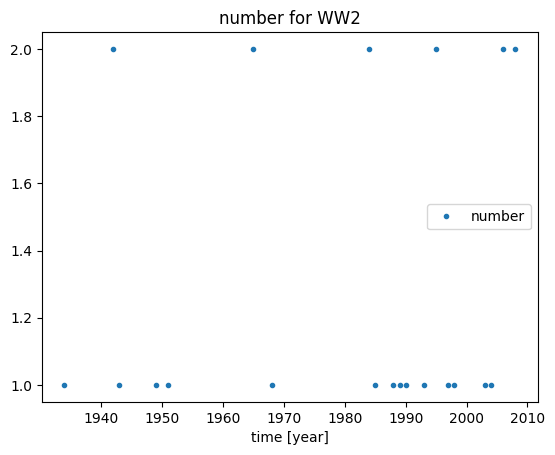

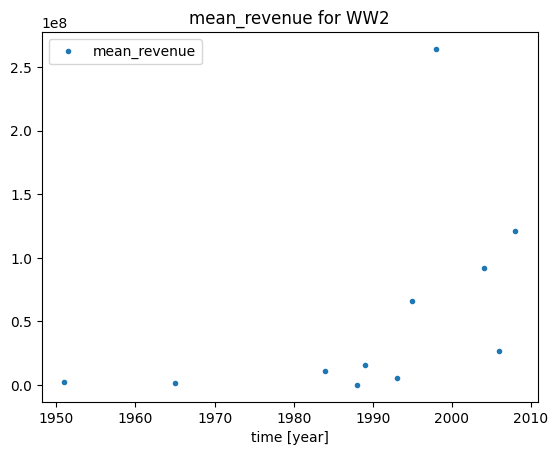

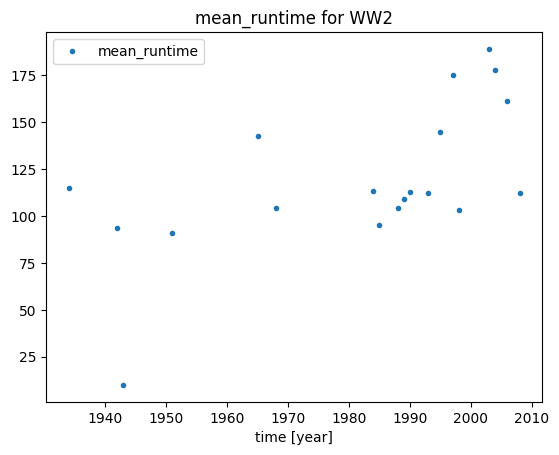

In [32]:
WW2_analysis = time_analysis('WW2',ww2T)
plot_time_analysis(WW2_analysis,'WW2')

In [33]:
print('on average, the box office revenue is: ', WW2_analysis.mean_revenue.mean(), 'and the runtime is : ', WW2_analysis.mean_runtime.mean())

on average, the box office revenue is:  55262646.63636363 and the runtime is :  119.23684210526316


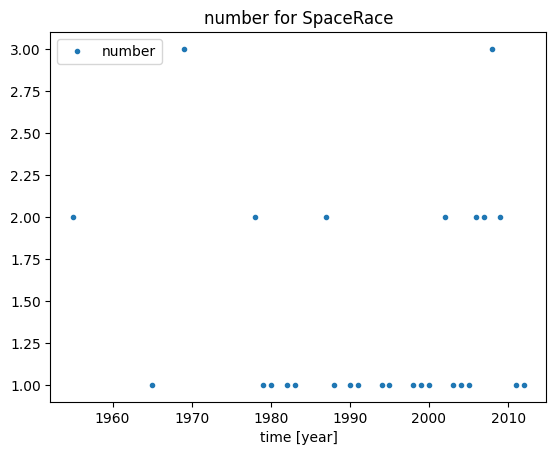

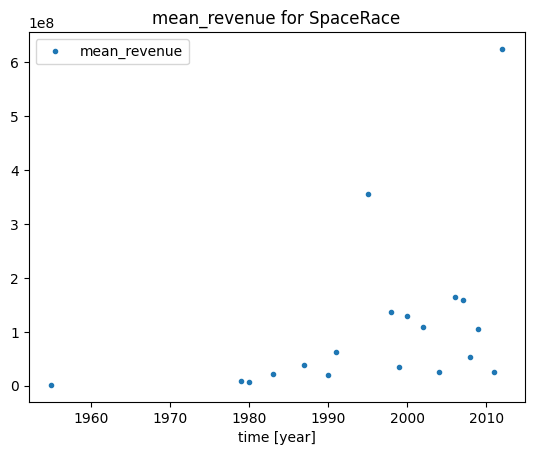

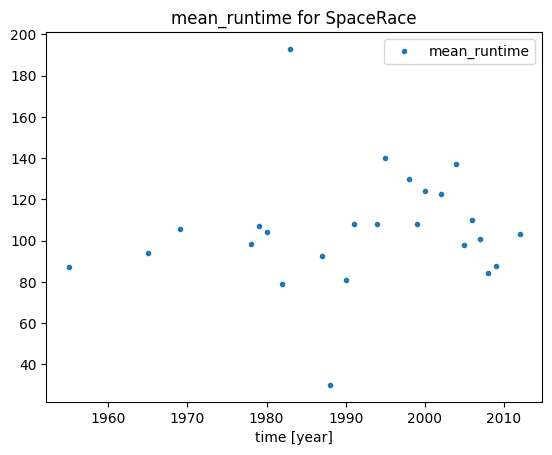

In [34]:
Space_analysis = time_analysis('SpaceRace',SpaceT)
plot_time_analysis(Space_analysis,'SpaceRace')

### Observe distribution and Linear Regression

In [35]:
def plot_distr():
    #to be completed with below example !
    return 0

C:\Users\Nate\AppData\Local\Temp\ipykernel_2084\2302834344.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  WW2_time_dist['Release_date'] = pd.to_datetime(WW2_time_dist['Release_date']).dt.year


Text(0.5, 1.0, 'Box office revenue distribution for WW2 event')

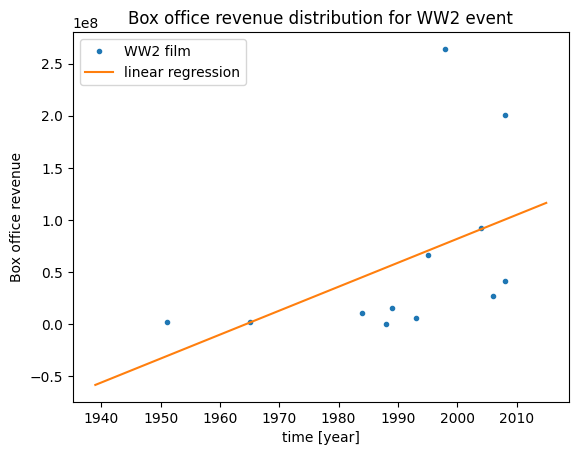

In [36]:
WW2_time_dist = movies_plot[movies_plot.WW2 > ww2T]
WW2_time_dist['Release_date'] = pd.to_datetime(WW2_time_dist['Release_date']).dt.year
WW2_time_dist = WW2_time_dist.dropna()
plt.plot(WW2_time_dist['Release_date'],WW2_time_dist['Box_office_revenue'],'.',label = 'WW2 film') 


X = np.array(WW2_time_dist['Release_date']).reshape(-1, 1)
reg = LinearRegression().fit(X, WW2_time_dist['Box_office_revenue'])
t = np.array(np.linspace(1939,2015,1000)).reshape(-1,1)
plt.plot(t,reg.predict(t),'-',label = 'linear regression')

plt.legend()
plt.xlabel('time [year]')
plt.ylabel('Box office revenue')
plt.title('Box office revenue distribution for WW2 event')

## Movie Genres analysis

In [37]:
movies_plot['Genres'] = movies_plot['Genres'].apply(lambda x: ', '.join(map(str, x)))
movies_plot.Genres = movies_plot.Genres.apply(lambda h: h.lower())
movies_plot.head(1)

,Wikipedia_movie_ID,Freebase_movie_ID,Name,Release_date,Box_office_revenue,Runtime,Languages,Countries,Genres,Summary,WW1,WW2,SpaceRace
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,English Language,United States of America,"thriller, science fiction, horror, adventure, ...","Set in the second half of the 22nd century, th...",1,0,1


In [38]:
genre_list = []
for genres in movies_plot['Genres']:
    for genre in genres:
        if genre not in genre_list:
            genre_list.append(genre)

In [198]:
len(genre_list)

363

In [ ]:
genre_list

In [39]:
movies_genres = ['Action', 'Adventure', 'Comedy', 'Fantasy', 'Historical', 'Horror', 'Satire', 'Science finction', 'Speculative',
                 'Thriller', 'Western', 'Drama', 'Horror', 'Documentary', 'Musical', 'Romance','Mystery', 'War', 'Biography', 'History',
                 'zombie film', 'Alien', 'Musical', 'anti-war', 'Black-and-white', 'Cold war', 'combat', 'Conspiration', 'crime', 
                'Documentary', 'Erotic', 'Gay', 'LGBT', 'Political', 'Romantic',  ]
movies_genres = [x.lower() for x in movies_genres]

In [40]:
for genre in movies_genres:
    movies_plot[genre] = movies_plot['Genres'].apply(lambda x: int(x.count(genre)>=1)) 

In [41]:
dictionnary_genres = pd.DataFrame()

In [42]:
dictionnary_genres

""


In [43]:
dictionnary_genres['WW1'] = movies_plot[movies_plot['WW1'] > ww1T][movies_genres].sum()
dictionnary_genres['WW2'] = movies_plot[movies_plot['WW2'] > ww2T][movies_genres].sum()
dictionnary_genres['SpaceRace'] = movies_plot[movies_plot['SpaceRace'] > SpaceT][movies_genres].sum()

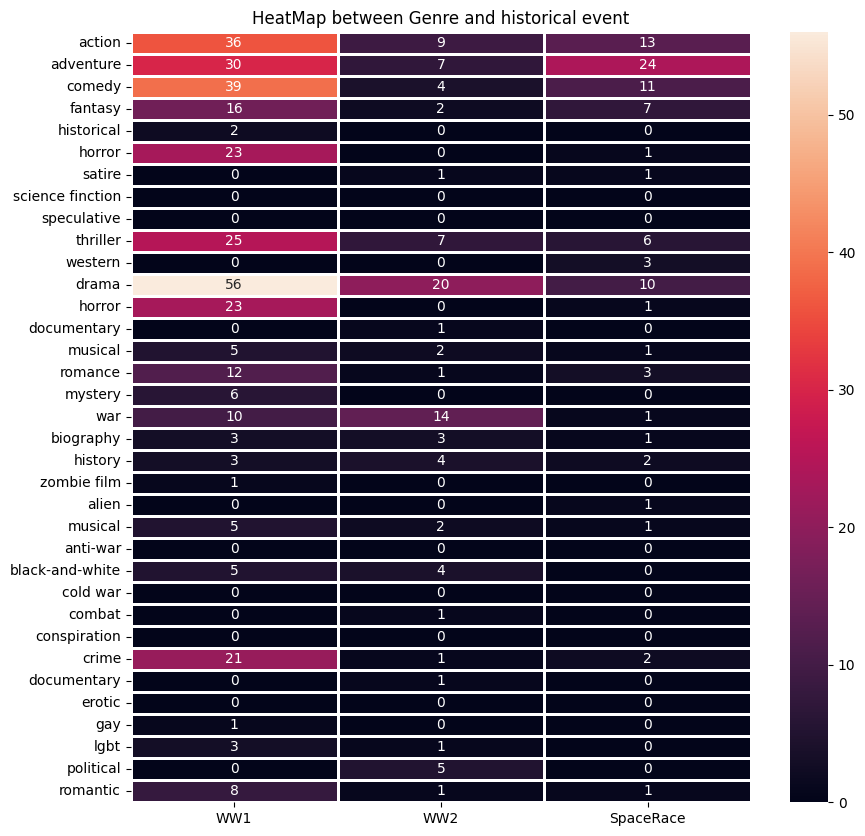

In [44]:
plt.figure(figsize=(10,10))
heat_map = sns.heatmap( dictionnary_genres, linewidth = 1 , annot = True)
plt.title( "HeatMap between Genre and historical event" )
plt.show()

In [224]:
erotique_analysis=time_analysis('Erotica', 0, freq='2y')
gay_analysis=time_analysis('Gay', 0, freq='2y')
lgbt_analysis=time_analysis('LGBT', 0, freq='2y')
WW1_analysis=time_analysis('WW1', 0, freq='2y')

<AxesSubplot: >

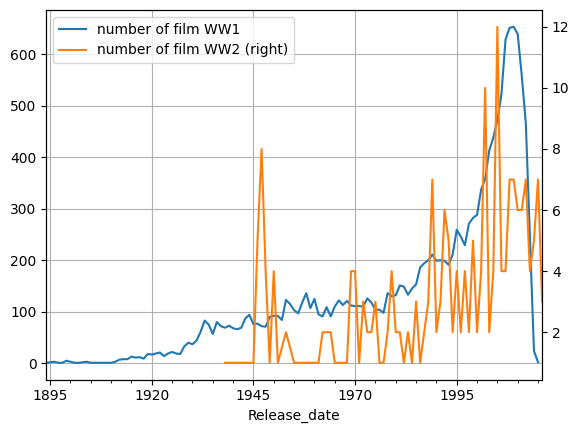

In [225]:
WW1_analysis.number.plot(grid=True, label="number of film WW1", legend=True)
WW2_analysis.number.plot(secondary_y=True, label="number of film WW2", legend=True)

<AxesSubplot: xlabel='Release_date'>

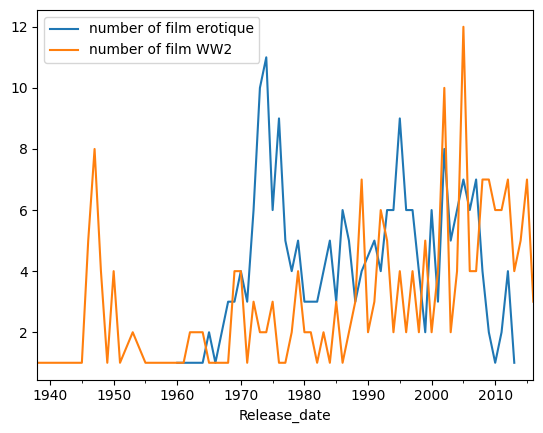

In [226]:
erotique_analysis.number.plot(grid=True, label="number of film erotique", legend=True)
WW2_analysis.number.plot(label="number of film WW2", legend=True)

<AxesSubplot: xlabel='Release_date'>

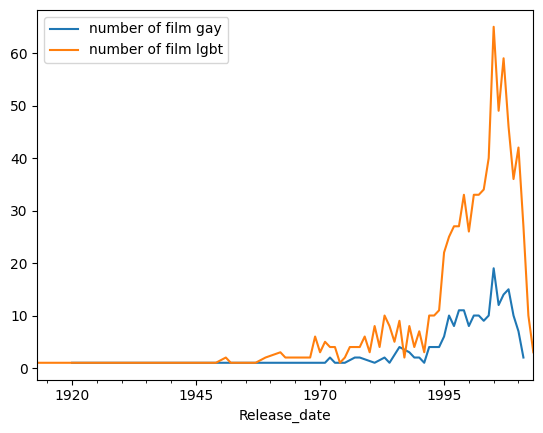

In [227]:
gay_analysis.number.plot(label="number of film gay", legend=True)
lgbt_analysis.number.plot(label="number of film lgbt", legend=True)

In [133]:
movies_plot.Countries

0                     United States of America
1                               United Kingdom
2                                      Germany
3                                 South Africa
4                     United States of America
                         ...                  
42199                           United Kingdom
42200                 United States of America
42201    Ireland", "/m/07ssc": "United Kingdom
42202                                    Japan
42203                                   Canada
Name: Countries, Length: 42204, dtype: object

## PCA 

define our feature we will use in PCA and normalize. Could define more feature by introducing character information i.e. gender ratio, age, height etc.. just need computation and fusion of DF.

-> start simple with 4 variables: box office, and the 3 events we have already

In [314]:
features = ['Box_office_revenue','WW1','WW2','SpaceRace']
PCAfeature = movies_plot[features].dropna()
PCAfeature= preprocessing.StandardScaler().fit(PCAfeature).transform(PCAfeature)
print(np.mean(PCAfeature,axis = 0),np.std(PCAfeature,axis = 0))

[ 2.66910083e-17 -5.66598596e-17 -3.27784312e-17  1.31113725e-17] [1. 1. 1. 1.]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


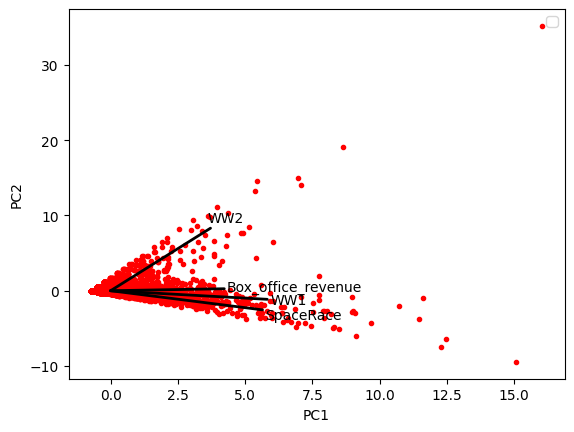

In [319]:
pca = PCA(2)  
projected = pca.fit_transform(PCAfeature)


ax = plt.gca()
arrowprops = dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0)

for i,f in enumerate(features):
    ax.annotate(f,[0,0],10*pca.components_[:,i],arrowprops= arrowprops)
    
plt.plot(projected[:, 0], projected[:, 1],'r.')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

## Kmean analysis

Same question here, which feature to take... For now, we will take the same as in the PCA section

In [334]:
features = ['Box_office_revenue','WW1','WW2','SpaceRace']
PCAfeature = movies_plot[features].dropna()
PCAfeature= preprocessing.StandardScaler().fit(PCAfeature).transform(PCAfeature) #
kmeans = KMeans(n_clusters=4, random_state=1).fit(PCAfeature)
kmeans.labels_

array([1, 1, 1, ..., 1, 1, 1])

We will plot the Kmean onto the 2 first PC

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


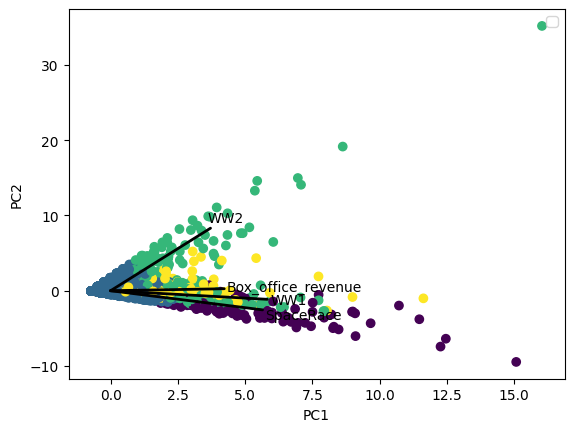

In [335]:
ax = plt.gca()
arrowprops = dict(arrowstyle='-',linewidth=2,shrinkA=0,shrinkB=0)

for i,f in enumerate(features):
    ax.annotate(f,[0,0],10*pca.components_[:,i],arrowprops= arrowprops)
    
plt.scatter(projected[:, 0], projected[:, 1],c = kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()

# Some vizualisation (Nono's excellent code)

In [50]:
values = []
counts = []
for v,c in merge_characters_type.groupby(by='Type') :
    values += [v]
    counts += [len(c)]
plt.figure(figsize=(20,10))
plt.vlines(values, 0, counts, color='C2', lw=4)
plt.ylim(0,max(counts))
plt.xticks(rotation='vertical')
plt.show()

In [51]:
values = []
counts = []
for v,c in merge_characters_type.groupby(by='Type') :
    values += [v]
    counts += [c.Box_office_revenue.mean()]
plt.figure(figsize=(20,10))
plt.vlines(values, 0, counts, color='C1', lw=4)
plt.ylim(0,max(counts))
plt.xticks(rotation='vertical')
plt.show()

In [52]:
merge_characters_type.Type.value_counts()

look for the crazy jalouse guy

In [53]:
Crazy_jalouse_guy = merge_characters_type.loc[merge_characters_type['Type'].isin(['crazy_jealous_guy'])]
Crazy_jalouse_guy.head(3)

In [54]:
b = Crazy_jalouse_guy.groupby((pd.to_datetime(Crazy_jalouse_guy['Movie_release_date']).dt.to_period(freq='10Y'))).apply(lambda x: pd.Series({
    'mean_height': x['Actor Height'].mean(),
    'mean_age' : x['Age_at_movie_release'].mean(),
    'mean_revenue' : x['Box_office_revenue'].mean(),
    'mean_runtime' : x['Runtime'].mean(),
    'number': x.Type.value_counts(), #verify that the number is not zero for a time period 
}))

In [55]:
b.mean_age.plot(grid=True, label="mean_age", legend=True)
b.mean_height.plot(secondary_y=True, label="mean_height", legend=True)

In [56]:
b.mean_revenue.plot(grid=True, label="mean_revenue", legend=True)
b.mean_runtime.plot(secondary_y=True, label="mean_runtime", legend=True)

In [57]:
Crazy_jalouse_guy.Actor_Ethnicity.value_counts() #mostly american

In [58]:
Crazy_jalouse_guy.movie.is_unique

In [59]:
sns.regplot(x='Age_at_movie_release', y='Actor_Gender', data=Crazy_jalouse_guy, logistic=True, ci=None)